# PYTHON CODE

#### IMPORT LIBRARIES

In [1]:
#pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language
#NumPy is the fundamental package for scientific computing in Python.
#Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python
# SciPy is a scientific computation library that uses NumPy underneath.
#mpltools provides tools for working with matplotlib


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
import endaq
from mpltools import layout

#### READ FILE INTO AN ARRAY

In [2]:
#creating a DataFrame object "df"

df = pd.read_excel(r'File_4.xlsx', header=None, engine="openpyxl") 
# Reads in Excel file to dataframe in Pandas

#convert the dataframe object df to a numpy array called "eeg_data"
eeg_data = df[0].to_numpy() 

#finds the size of the numpy array
print(
    f'The original eeg data has {eeg_data.size} samples'
)         

The original eeg data has 30000 samples


#### CREATION OF TIME STEPS AND CALCULATION OF DURATION OF SIGNAL

In [3]:
Fs = 500 # Sampling Frequency
Recording_Length= eeg_data.size/(60*Fs) # Number of minutes of EEG Recorded
print(f'The recording is {Recording_Length} minutes long') 

The recording is 1.0 minutes long


#### TIME PLOT OF EEG SIGNAL

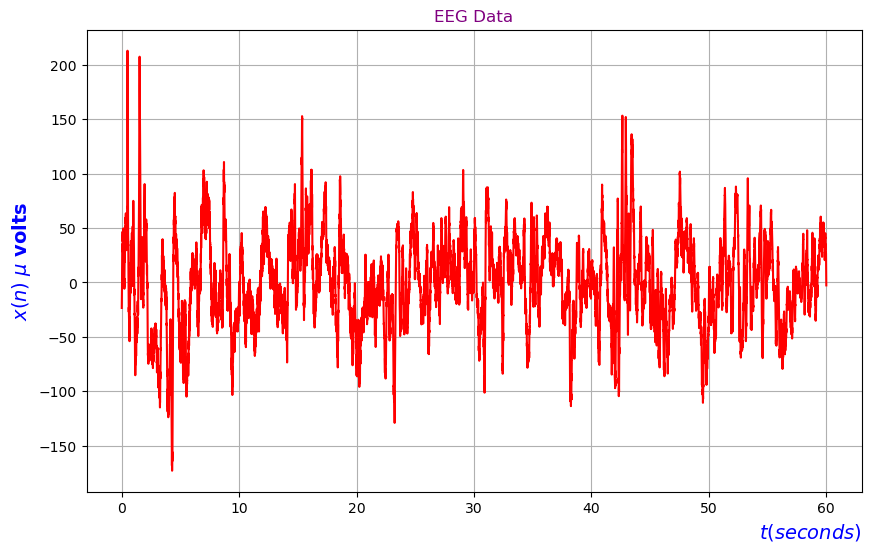

In [4]:
# Converting the eeg index to seconds by creating time-steps
recordtimeinseconds = np.arange(0,len(eeg_data),1)/(Fs) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(recordtimeinseconds,eeg_data, color='red') #time on x-axis, eeg_data on y axis
plt.title("EEG Data", color ="purple") #title and color of title

#labeling the x and y axis
plt.ylabel('$x(n)\  \mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    weight="bold",horizontalalignment='right', x=1.0
)

#To show grid lines in the plot
plt.grid(True)

#### SPECTRUM ANALYSIS OF SIGNAL

In [5]:
#the Welch function is used to compute an estimate of the 
# power spectral density by dividing the data into 
# overlapping segments, computing a modified periodogram for 
# each segment and averaging the periodograms
#f --> array of sample frequencies,
#EEG_welchperiodogram -> power spectral density of eeg_data

f, EEG_welchperiodogram =  signal.welch(
    eeg_data, Fs, 'boxcar', 
    nperseg=1024, detrend=False
) 


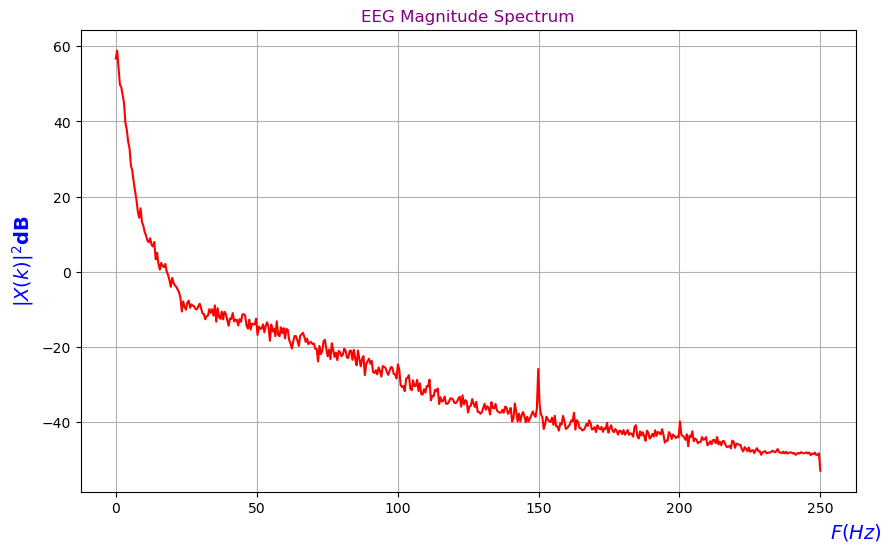

In [6]:
#dimensions for the plot
plt.figure(figsize = (10,6)) # 10 in by 6 in

#plot of power spectral density in dB against frequencies f
plt.plot(f, 20*np.log10(EEG_welchperiodogram), color='red')

#title of plot, color of text of plot title
plt.title("EEG Magnitude Spectrum", color ="purple")


#labels for x and y axis
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F (Hz)$', fontsize=14, color="blue", weight="bold",  x=1.0)

#show grid plot grid lines
plt.grid(True)

#### UPSAMPLING SIGNAL, FIRST STAGE OF RESAMPLING


##### determining interpolation and decimation factors

In [7]:
#The first stage involves an upsampler with a 
#Low pass Anti-aliasing filter

#final desired sampling frequency is 32 Hz
desired_samp_freq = 32

#The lcm of the initial sampling frequency 'Fs' and desired sampling freq
intermediate_freq = math.lcm(Fs, desired_samp_freq)

#Calculating the interpolation and decimation factors
L = intermediate_freq // Fs
M = intermediate_freq // desired_samp_freq

#print factors L and M to the console
print(f"The interpolation factor L = {L} , and the decimation factor M = {M}")

The interpolation factor L = 8 , and the decimation factor M = 125


##### function to upsample from 500 Hz to 4000 Hz 

In [8]:
#custom function to upsample by inserting L-1 zeros 
#between consecutive samples
#takes the unsampled signal, current sample freq and desired
#up sample frequency as arguments
def upsample(data_samples, up_samp_freq, freq):
    """
    Performs an upsampling of an array of data by
    inserting L-1 zeros (L =up_samp_freq//freq) between
    consecutive datapoints in that array

    Arguments:
        data_samples: array data set to be upsmapled
        up_samp_freq: desired up sample frequency
        freq: current sampling frequency of the data_samples

    Returns:
        sampled_data: The newly sampled data set with a higher sampling
        frequency, i,e more data points
    """
    samples = up_samp_freq * 60
    L = up_samp_freq // freq
    blank_list = []
    for i in range(data_samples.size -1):
        blank_list.append(data_samples[i])
        for i in range(1, L):
            blank_list.append(0)
    sampled_data = np.array(blank_list)
    return sampled_data
    

##### desired up-sample frequency

In [9]:
#determining the up_sample frequency and down_sample frequency
#using the values of L and M calculated earlier
up_sample_frequency = L * 500
up_sample_frequency
down_sample_frequency = intermediate_freq // M
print(
    f"Upsampled signal frequency would be {up_sample_frequency}Hz",
f"Downsampled OR resampled signal frequency would be {down_sample_frequency}Hz"
)

Upsampled signal frequency would be 4000Hz Downsampled OR resampled signal frequency would be 32Hz


##### generating the up-sampled digital eeg signal

In [10]:
#upsample the eeg_data from 500 Hz to 4000Hz
#using the function defined in the previous two cells.
#returns a new signal  "upsampled_eeg" with a higher sample freq 
upsampled_eeg = upsample(data_samples=eeg_data, up_samp_freq=4000, freq=500)


##### One-sided power spectrum density values for the up-sampled signal

In [11]:
#f --> array of sample frequencies,
#upsample_signal_mag -> power spectral density of new_eeg_data
#Scipy's welch method once again helps in plotting power spectral density
f, upsample_signal_mag =  signal.welch(
    upsampled_eeg, 4000, 'boxcar', 
    nperseg=1024, detrend=False
) 

#### TIME PLOT OF UPSAMPLED SIGNAL (4,000 Hz)

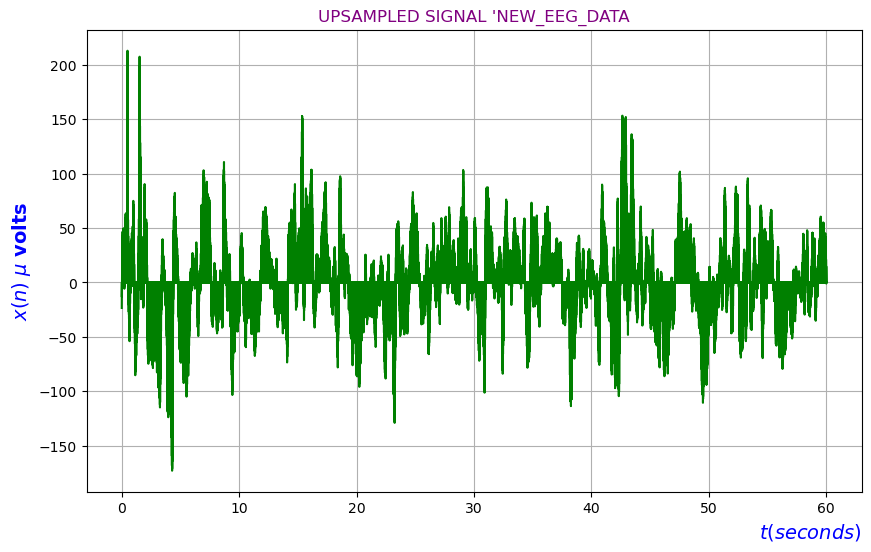

In [12]:
# Converting upsampled_eeg index to seconds by creating time-steps
recordtimeinseconds = np.arange(0,len(upsampled_eeg),1)/(up_sample_frequency) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(recordtimeinseconds,upsampled_eeg, color="green") #time on x-axis, eeg_data on y axis

#title and color of title
plt.title(
    "UPSAMPLED SIGNAL 'NEW_EEG_DATA", 
    color ="purple"
) 

#labeling the x and y axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    weight="bold",horizontalalignment='right', x=1.0
)

#To show grid lines in the plot
plt.grid(True)

### SPECTRUM ANALYSIS OF UP-SAMPLED SIGNAL (4,000 HZ)

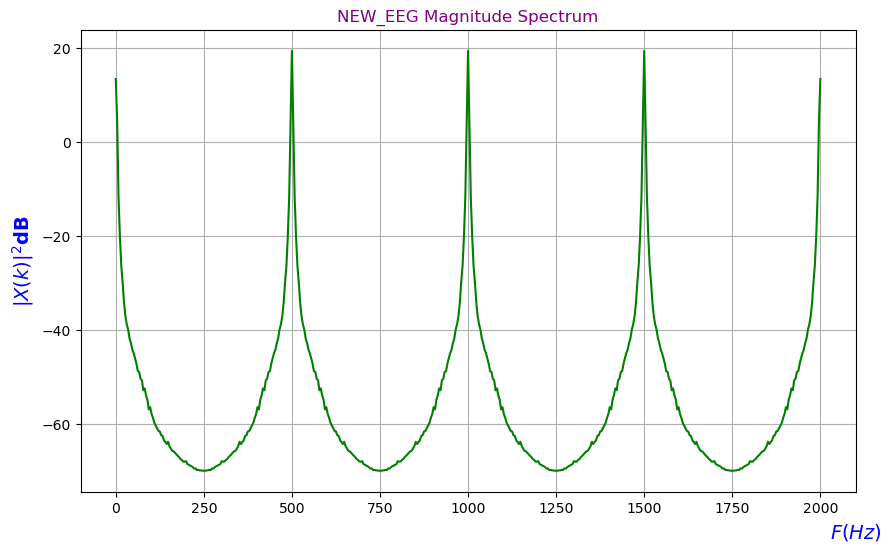

In [13]:
#dimension of plot
plt.figure(figsize = (10,6)) # 10 in by 6 in

#power spectral density in dB against frequency up to 2000 Hz (Fs/2)
plt.plot(f, 20*np.log10(upsample_signal_mag), color='green')

#title of the plot and color of the title's text
plt.title("NEW_EEG Magnitude Spectrum", color ="purple")

#x axis and y-axis 
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F (Hz)$', fontsize=14, color="blue", weight="bold",  x=1.0)

#To show grid lines in the plot
plt.grid(True)


#### DESIGN OF LOW PASS ANTI-ALIASING INTERPOLATION FILTER

In [14]:
#The function lp_filter_specs computes the filter specifications
#Transition bandwidth, cut-off frequency, bandwidth, and stopband frequency
#of the low pass filter
#the factors L, M the origiinal sample frequncy, intermediate frequency and 
#bandwidth B are passed as arguments

def lp_filter_specs(L, M, Fs_old, Fs_new, B):
    '''
    Calculates filter parameters transition bandwidth, cut_off frequency,
    stopband frequency and Bandwidth i.e passband edge frequency for 
    the low pass interpolation filter.

    Arguments:
        L: interpolation factor
        M: Decimation factor
        Fs_old: The frequency of the signal before upsampling
        Fs_new: current sampling frequency of the signal
        B: Passband edge frequency
    
    Returns:
        parameters: A list of transition bandwith, current sampling frequency,
        previous sampling frequency and Passband edge frequency

    '''
    l = (1 / (2 * L))
    m = (1 / (2 * M))
    transition_bw = (Fs_new / (2 * L) - B)/ Fs_new
    cut_off_freq = Fs_new / (2 * L) - (transition_bw / 2)
    stop_band = Fs_new / (2 * L)
    parameters = []
    if l < m:
        transition_bw = ((Fs_old/2) - B)/ (L * Fs_old)
        parameters.extend([transition_bw, cut_off_freq, B, stop_band])
    else:
        transition_bw = ((Fs_new /(2 * M)) - B)/ (Fs_new)
        cut_off_freq = (B / Fs_new) + (transition_bw / 2)
        stop_band = (B / Fs_new) + transition_bw
        parameters.extend([transition_bw * Fs_new, cut_off_freq * Fs_new, B, stop_band * Fs_new])

    parameters = np.round(np.array(parameters), 3)
    return parameters
    
    
    

In [15]:
#the filter requirements as in cell 14 are passed as arguments 
lp_tbw, lp_cfreq, bw, lp_stfreq = tuple(lp_filter_specs(8, 125, 500, 4000, 13))

#print out the requirements to the console
print(
    f"low pass interpolation filter transition bandwidth {lp_tbw}," 
    f"low pass interpolation filter cut-off frequency {lp_cfreq}," 
    f"Bandwidth {bw}, stopband frequency {lp_stfreq}"
)

low pass interpolation filter transition bandwidth 3.0,low pass interpolation filter cut-off frequency 14.5,Bandwidth 13.0, stopband frequency 16.0


In [16]:
#determining number of filter taps used for a hamming window design
MLP = int(np.ceil(3.3 * 4000 /(lp_tbw) ))
MLP

4400

In [17]:
#rounding up to an odd value
MLP += 1
print(
    f' Low pass interpolation filter to be used would have'
    f' {MLP} filter taps'
)

 Low pass interpolation filter to be used would have 4401 filter taps


In [18]:
#Determining h(0) of the low pass interpolation filter
Midpoint = int((MLP -1)/2)
print(
    f'Midpoint h(0) of the Linear phase positive symmetry Low pass'
    f'FIR filter is {2200}'
)

Midpoint h(0) of the Linear phase positive symmetry Low passFIR filter is 2200


In [19]:
#computing the Low pass impulse domain coeffiecients
#using scipy's firwin function
ncoeffLP = signal.firwin(
    MLP, lp_cfreq, window = 'hamming',
     fs = 4000, pass_zero=True
) 

#### IMPULSE RESPONSE AND FREQUENCY RESPONSE OF THE LOW PASS INTERPOLATION FILTER USED

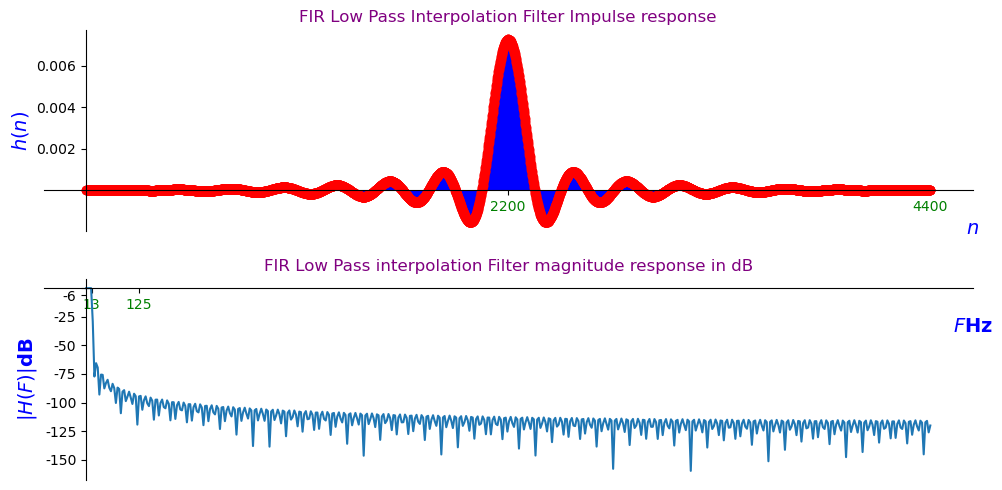

In [20]:
#To determine the frequency response of the signal
w, HWLP = signal.freqz(ncoeffLP, fs = 4000)
plt.figure(figsize = (10,5)) # 10 in by 5 in
#create a subplot 2 rows and one column
plt.subplot(211)
plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title(
    "FIR Low Pass Interpolation Filter Impulse response", 
    color ="purple"
)

#x and y axis of the first subplot
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,Midpoint,MLP-1], color="green")
#plt.yticks([-0.01,0.048,0.05])
#plt.axis([0,M-1,-0.015,0.05])


#creates a second subplot on the second row
plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWLP)))
plt.title(
    "FIR Low Pass interpolation Filter magnitude response in dB",
    color ="purple"
 )

#x and y axis of the second subplot
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold") 
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)

#to tick crucial points on the frequency response graph
plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
plt.xticks([13,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots

In [21]:
#multipling the co-efficients of the filter with the upsampled signal
#in the time domain
#and storing the filtered signal in a new variable "interpolated_eeg"
interpolated_eeg = signal.lfilter((8 * ncoeffLP), [1.0], upsampled_eeg)

In [22]:

#welch method already discusssed before nperseg here is set as 2048, 
#2048 is the lower exponent of 2 closest to 4000 samples in one second
f, EEG_welchperiodogram1 =  signal.welch(
    interpolated_eeg, 4000, 'boxcar', nperseg=2048,
    detrend=False
) 

#### SPECTRUM ANALYSIS OF UPSAMPLED FILTERED SIGNAL AFTER THE LOW PASS INTERPOLATION FILTER

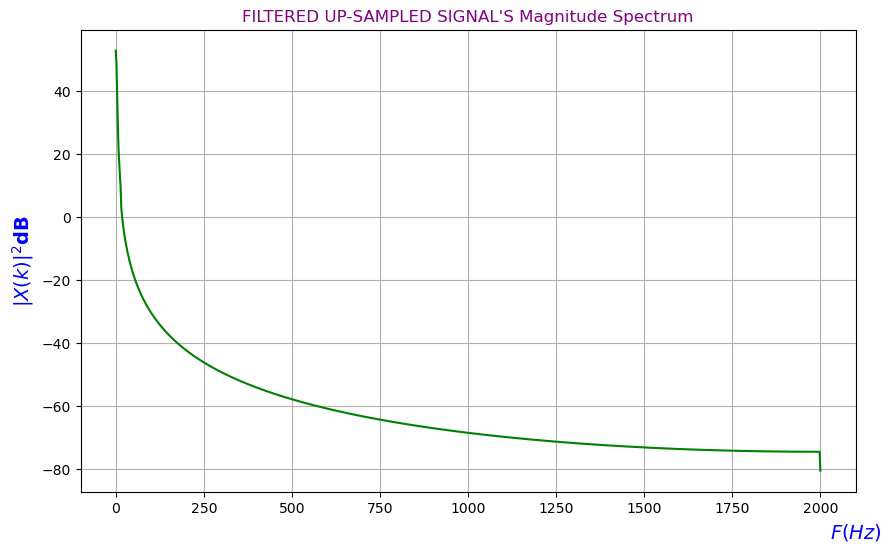

In [23]:
#dimension of plot
plt.figure(figsize = (10,6)) # 10 in by 6 in

#Power spectral density in decibel against Frequency in Hertz
plt.plot(f, 20*np.log10(EEG_welchperiodogram1), color='green')

#title of plot
plt.title("FILTERED UP-SAMPLED SIGNAL'S Magnitude Spectrum", color ="purple")

#x and y axis of plot
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F (Hz)$', fontsize=14, color="blue", weight="bold",  x=1.0)

#show grid lines for plot
plt.grid(True)

#### COMPARISON OF original eeg_data, upsampled_eeg_data and interpolated_eeg

<AxesSubplot:title={'center':'smoothened filtered signal using low pass Anti-Aliasing interpolation filter right before Decimation'}, xlabel='samples (n)', ylabel='x(n)'>

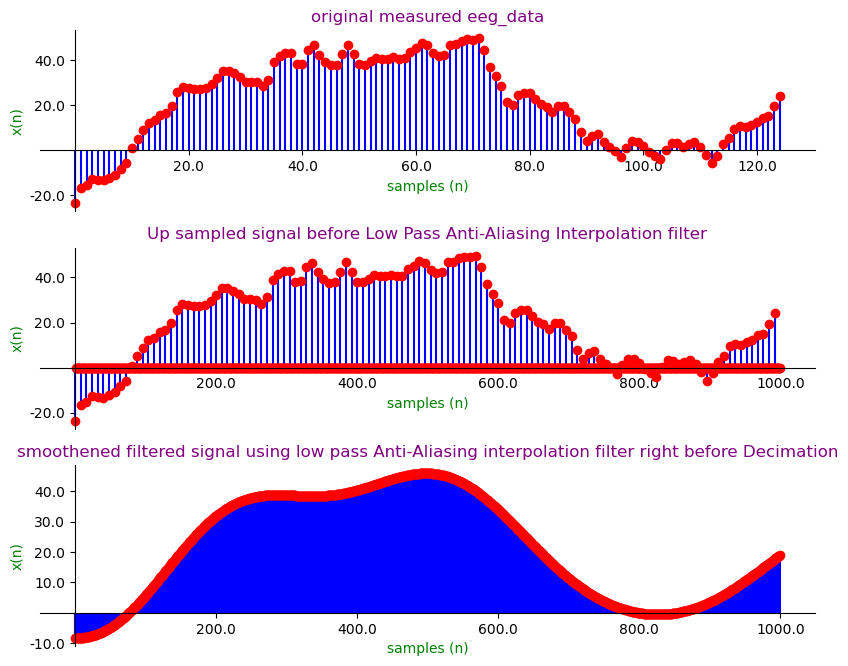

In [24]:
samples = np.arange(start=0, stop=23992)

plt.figure(figsize=(10, 8))

#plot on the first row
plt.subplot(311)
plt.xlabel("samples (n)", color="green")
plt.ylabel("x(n)", color="green")
plt.title("original measured eeg_data", color="purple")
layout.cross_spines(zero_cross=True)
plt.stem(eeg_data[:125], linefmt="blue", markerfmt="ro", use_line_collection=True, basefmt=" ")

#plot on the second row
plt.subplot(312)
plt.xlabel("samples (n)", color="green")
plt.ylabel("x(n)", color="green")
plt.title("Up sampled signal before Low Pass Anti-Aliasing Interpolation filter", color="purple")
layout.cross_spines(zero_cross=True)
plt.stem(upsampled_eeg[:1000], linefmt="blue", markerfmt="ro", use_line_collection=True, basefmt=" ")


#plot on the third row
plt.subplot(313)
plt.xlabel("samples (n)", color="green")
plt.ylabel("x(n)", color="green")
plt.title("smoothened filtered signal using low pass Anti-Aliasing interpolation filter right before Decimation", color="purple")
plt.stem(interpolated_eeg[Midpoint:1000 + Midpoint], linefmt="blue", markerfmt="ro", use_line_collection=True, basefmt=" ")
layout.cross_spines(zero_cross=True)


#### TIME PLOT OF UPSAMPLED SIGNAL AFTER THE INTERPOLATION FILTER

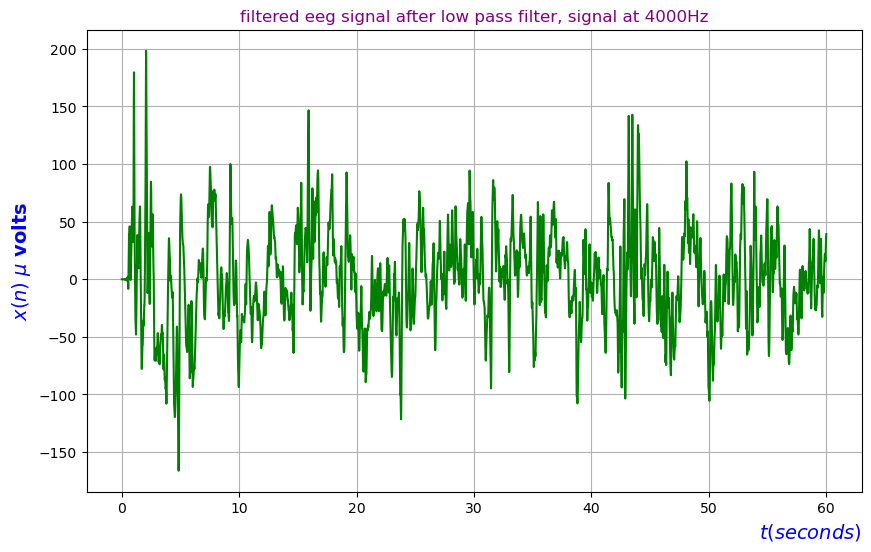

In [25]:
recordtimeinseconds = np.arange(0,len(interpolated_eeg),1)/(up_sample_frequency) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(recordtimeinseconds, interpolated_eeg, color="green") #time on x-axis, eeg_data on y axis

#title and color of title
plt.title(
    "filtered eeg signal after low pass filter, signal at 4000Hz", 
    color ="purple"
) 

#labeling the x and y axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    weight="bold",horizontalalignment='right', x=1.0
)

#To show grid lines in the plot
plt.grid(True)

#### DOWNSMAPLING - Decimation


In [26]:
#custom function to down sample by removing M-1 samples for every M samples
#takes the data samples to be down sampled, current sample freq and desired
#down sample frequency as arguments
def down_sample(data_samples , down_samp_freq, freq):
    M = (freq // down_samp_freq) - 1
    new_signal = []
    count = 0
    while count < data_samples.size:
        new_signal.append(data_samples[count])
        count += M + 1
    return np.array(new_signal)



In [27]:
#creates a down sampled signal "downsampled_signal" from
#"filtered_eeg"
downsampled_signal = down_sample(interpolated_eeg, 32, 4000)

Confirming frequency is indeed 32


In [28]:
sample_Freq_new = (downsampled_signal.size // 60 )
print(f"frquency of 'downsampled_signal' is {sample_Freq_new} Hz")

frquency of 'downsampled_signal' is 32 Hz


#### TIME PLOT OF RESAMPLED SIGNAL AFTER DECIMATION

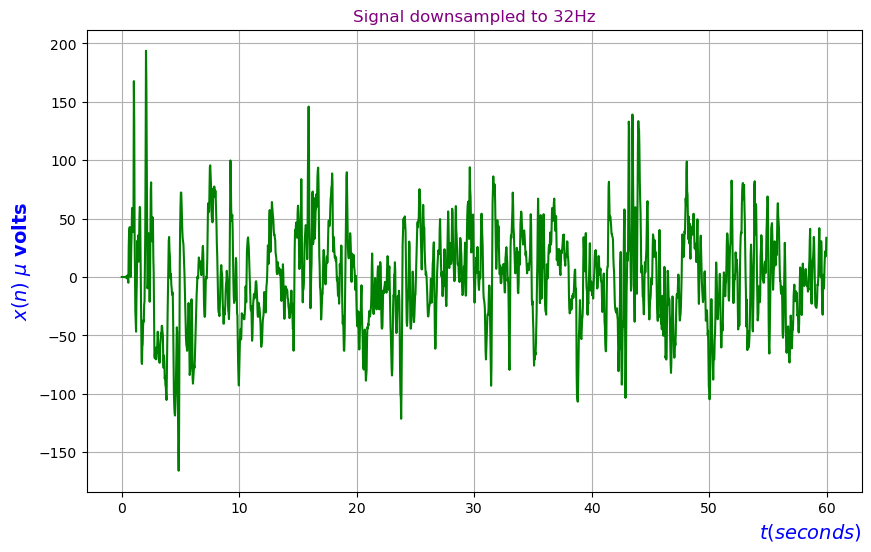

In [29]:
# Converting new_eeg index to seconds by creating time-steps
recordtimeinseconds = np.arange(0,len(downsampled_signal),1)/(down_sample_frequency) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(recordtimeinseconds, downsampled_signal, color="green") #time on x-axis, eeg_data on y axis

#title and color of title
plt.title(
    "Signal downsampled to 32Hz", 
    color ="purple"
) 

#labeling the x and y axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    weight="bold",horizontalalignment='right', x=1.0
)

#To show grid lines in the plot
plt.grid(True)

#### DESIGN OF HIGH PASS FILTER TO ELIMINATE DC OFFSET


In [30]:
#pass band of the high pass filter is 0.5Hz
#cut-off frequency of the high pass filter is 0.25Hz 
HPpassband = 0.5
HPtransition_band = 0.5
HPcut_off_freq = 0.5 - (0.5/ 2)
print(f"cut-off freqency for the High Pass filter is {HPcut_off_freq}")

cut-off freqency for the High Pass filter is 0.25


In [31]:
sample_Freq_new

32

In [32]:
#calculating filter taps using a blackman window
M = int(math.ceil(5.5 * sample_Freq_new / HPtransition_band))
print(f"M = {M}")

M = 352


In [33]:
M += 1
print(f'M odd = 353')

M odd = 353


In [34]:
HPMid_point = (M -1)//2
print(f'filer tap midpoint h(0) = {HPMid_point}')

filer tap midpoint h(0) = 176


In [35]:
#computing filter co-efficients of the high pass filter requirements
#in the previous cells above

ncoeffHP = signal.firwin(
    M, HPcut_off_freq, window = 'blackman', 
    fs = sample_Freq_new, pass_zero=False
) 

In [36]:
#The final preprocessed signal before machine learning algorithms
#are applied 

preprocessed_signal = signal.lfilter(ncoeffHP, [1.0], downsampled_signal)

#### COMPARISON OF INITIAL SIGNAL SAMPLED AT 500Hz and PREPROCESSED SIGNAL RESAMPLED TO 32HZ

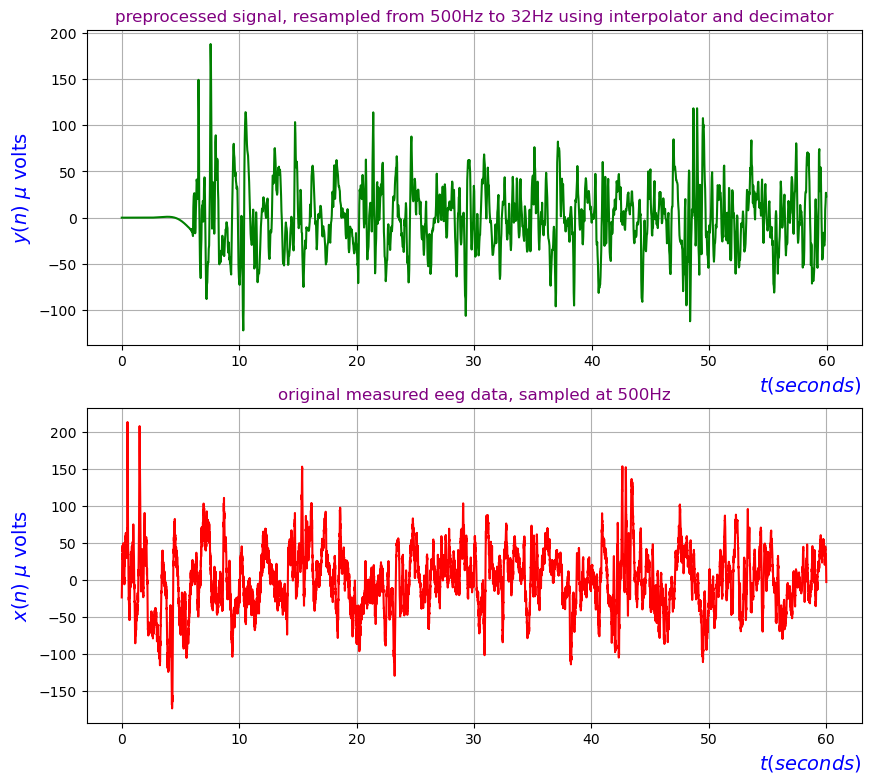

In [37]:
#to create points for time, 1 second until 60 seconds
recordtimeinseconds = np.arange(0,len(preprocessed_signal),1)/(32) 

#set the dimension of the plot, using the value of the tuple, passed
#to the figsize argument
plt.figure(figsize=(10,9))
plt.subplot(211)

#sets the title and color of the title
plt.title(
    "preprocessed signal, resampled from"
    " 500Hz to 32Hz using interpolator and decimator",
    color="Purple" 
)

#formats and labels the x axis and the y-axis
plt.ylabel('$y(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
#plots the preprocessed signal on the y axis and the time in seconds on the
#x-axis in green
plt.plot(recordtimeinseconds, preprocessed_signal, color="Green")
plt.grid(True)  #show grid lines in the plot 


#create a subplot for a second graph
plt.subplot(212)
#to create points for time, 1 second until 60 seconds
recordtimeinseconds = np.arange(0,len(eeg_data),1)/(500)
#sets the title and color of the title 
plt.title(
    "original measured eeg data, sampled at 500Hz",
    color="Purple" 
)

#formats and labels the x axis and the y-axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
#plots the original signal on the y axis and the time in seconds on the
#x-axis in green
plt.plot(recordtimeinseconds, eeg_data, color="Red")
plt.grid(True) #show grid lines in the plot



##### Closer look at the initial signal and resampled signal at a 3 seconds interval

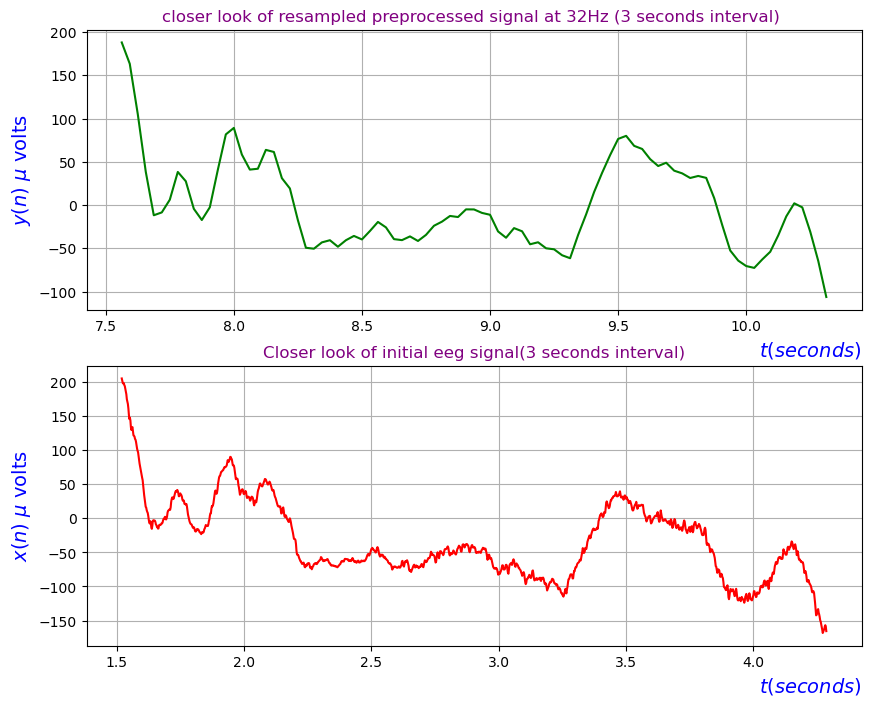

In [38]:
#create the dimension of the plot...10 by 8
plt.figure(figsize=(10,8))

#creates a subplot in the plot described earlier
plt.subplot(211)
#sets the title and color of the title
plt.title(
    "closer look of resampled preprocessed signal"
    " at 32Hz (3 seconds interval) ", color="purple"
    )
    
#plots a slice of the preprocessed signal on the y axis and the time in
#  seconds on the x-axis in green
plt.plot((np.arange(242, 331)/32), preprocessed_signal[242:331], color="green")
plt.ylabel('$y(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
plt.grid(True)


plt.subplot(212)
plt.title(
    "Closer look of initial eeg signal"
    "(3 seconds interval)", color="purple"
)

#plots a slice of the original eeg signal on the y axis and the time in
#  seconds on the x-axis in green
plt.plot((np.arange(760, 2144)/500), eeg_data[760: 2144], color="Red")

#formats and labels the x axis and the y-axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
plt.grid(True)

#### CREATING 8 SECONDS EPOCHS WITH 50% OVERLAP FOR THE PREPROCESSED SIGNAL 


In [39]:
Epochs_data_points = (preprocessed_signal.size / 60) * 8
print(
    f"There are {int(Epochs_data_points)} data samples in each epoch, and"
    " each epoch lasts 8 seconds"
)

There are 256 data samples in each epoch, and each epoch lasts 8 seconds


In [40]:
#This function creates epochs of a data_set, takes in
#the data_set and the number of samples that make up each epoch

def create_epochs(array_data_set, samples_per_epoch):
    '''
    The function takes in a array data set and returns epochs of the
    data set with a 50% overlap.

    Parameters:
        array_data_set: The data_set to create epochs from
        samples_per_epoch: The number of samples that would be contained
        in each epoch

    Return:
        epochs: An array of epochs each of length: samples_per_epoch
    
    '''
    left_bound = 0
    right_bound = samples_per_epoch - 1
    epochs = []
    while right_bound <= array_data_set.size:
        epochs.append(np.array(array_data_set[left_bound: right_bound + 1]))
        left_bound += (samples_per_epoch) // 2
        right_bound += (samples_per_epoch) // 2
    epochs = np.array(epochs, dtype=float)
    return epochs

In [41]:
#create epochs of the preprocessed signal of 8 seconds with 50% overlap
epochs_resampled_eeg = create_epochs(
    preprocessed_signal, 
    samples_per_epoch=int(Epochs_data_points)
)
#get the number of epochs created 
N_epochs = len(epochs_resampled_eeg)
print(f'There are a total of {N_epochs} epochs')

There are a total of 14 epochs


In [42]:
#A function definition to plot the Power spectral density of the first 9 epochs
def plot_epochs_spectrum(e):
    '''

    A function that plots the Power spectral density of an array of epochs

    Parameters: 
        e: Array like, list of all the epochs
    Returns:
        None
    '''
    i = 1
    plt.figure(figsize=(15, 15))
    for epoch in e:
        n = int(f"43{i}")
        f, psd =  signal.welch(epoch, 32, 'boxcar', nperseg=256, detrend=False)
        plt.subplot(n)
        psd = np.array(psd, dtype=float)
        plt.plot(f, 20*(np.log10(psd)), color="green")
        plt.title(f"Epoch {i}", color="purple")
        plt.grid(True)
        i += 1
    


#### Power Spectral Density of the first 9 epochs OF THE PREPROCESSED SIGNAL (32Hz)

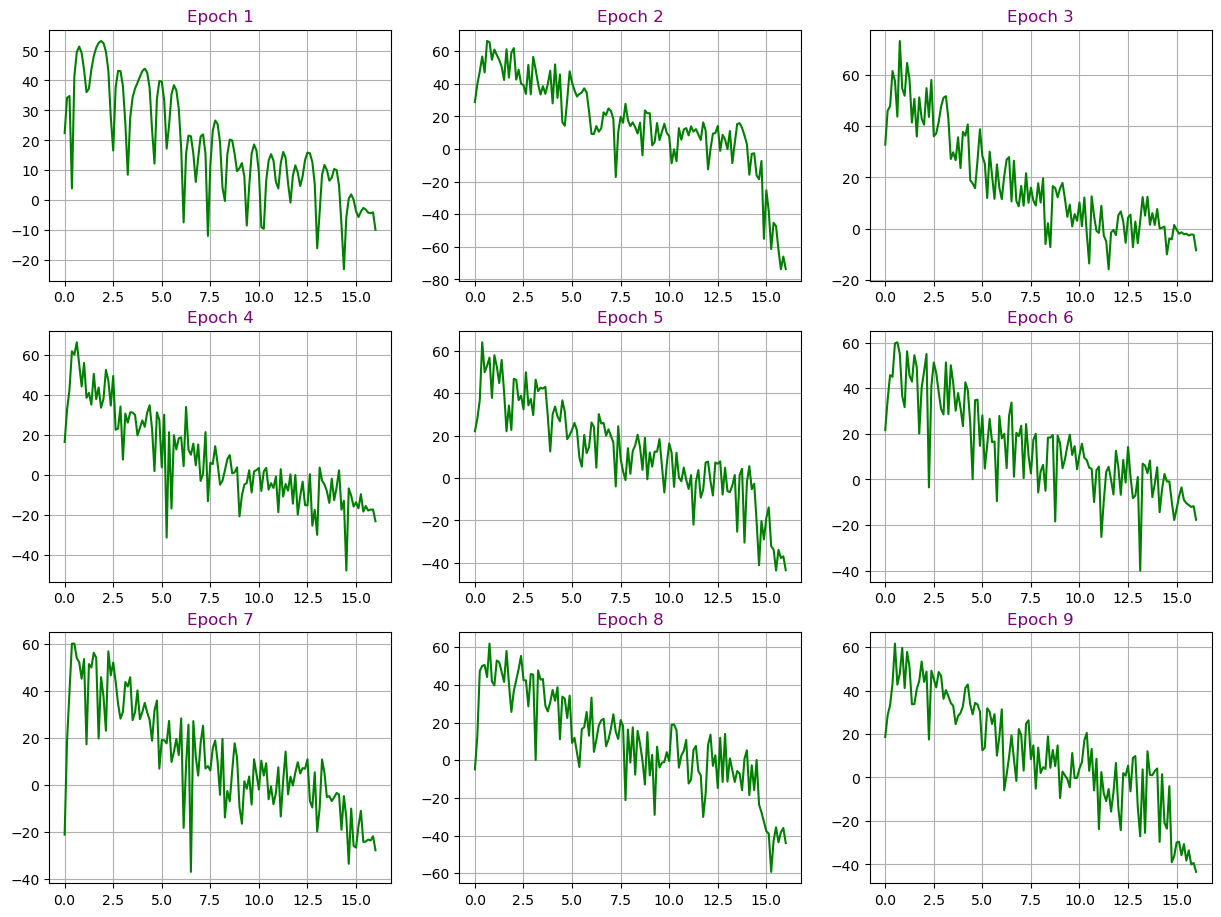

In [43]:
#uisng the plot_epochs_spectrum to plot the power spectral density 
#of the first 9 epochs
plot_epochs_spectrum(e=epochs_resampled_eeg[0:9])

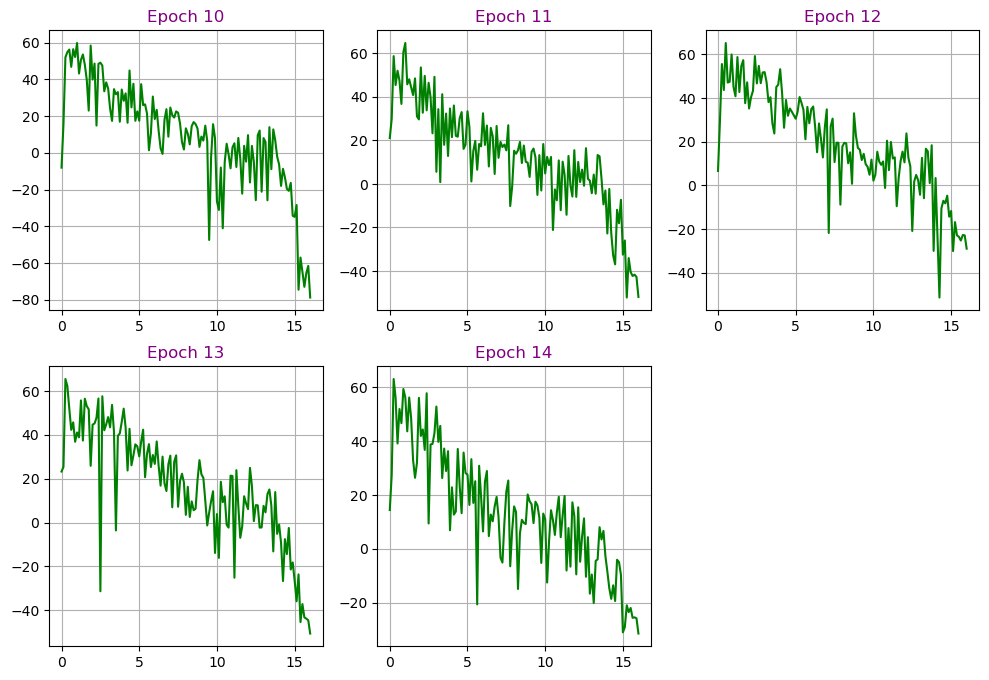

In [44]:
#procedural code section to plot the power spectral density of the 
#remaining 5 epochs of the preprocessed signal
i = 1
num = 10
plt.figure(figsize=(12,8))
for epoch in epochs_resampled_eeg[9:]:
        n = int(f"23{i}")
        f, psd =  signal.welch(epoch, 32, 'boxcar', nperseg=256, detrend=False)
        plt.subplot(n)
        psd = np.array(psd, dtype=float)
        plt.plot(f, 20*(np.log10(psd)), color="green")
        plt.title(f"Epoch {num}", color="purple")
        plt.grid(True)
        i += 1
        num += 1 

#### INTENSITY WEIGHTED MEAN FREQUENCY CALCULATION for preprocessed signal

In [45]:
# This function computes the Intensity Weighted Mean frequency
#of each epoch using the estimate of each epoch's spectrum

def calc_iwmf(epochs, N, Fs):
    """
    Calculates the Intensity Weighted Mean Frequency of each array in
    a 2D array and returns a list of all IWMF values calculated

    Parameters:
        epochs: a 2-D array object
        N: Number of DTFT points used, number of frequeny bins used for 
        power spectral density estimation
        Fs: The frequency at which the data points were sampled

    Returns:
        a list of calculated IWMF values 
    """
    iwmf_list = []
    df = Fs / N
    for epoch in epochs:
        psd_sum = 0
        numerator_sum = 0
        f, psd =  signal.welch(epoch, fs=Fs, window='boxcar', nperseg=N, detrend=False,)
        for i in range(len(psd)):
            psd_sum += psd[i]
            numerator_sum += psd[i] * i * df
        iwmf_list.append(numerator_sum / psd_sum)
    return iwmf_list

In [46]:
#create a list of iwmf values calculate for each epoch of the preprocessed
#signal

iwmf_list = calc_iwmf(epochs=epochs_resampled_eeg, N=256, Fs=32)


In [47]:
print(
    "Intensity weighted mean frequency values"
    " for the preprocessed digital siganl" 
    "resampled to 32Hz"
    f''' are: 
    {iwmf_list}'''
)

Intensity weighted mean frequency values for the preprocessed digital siganlresampled to 32Hz are: 
    [2.6565298338612435, 1.8567808111765849, 1.4646408606182961, 1.240544055971253, 1.6820811613424436, 1.935697110944813, 1.714600385742966, 1.941197454174903, 1.9133151528913663, 1.7337344732757383, 1.666243984317254, 2.209431191485749, 2.1427017779159745, 1.7170036619538966]


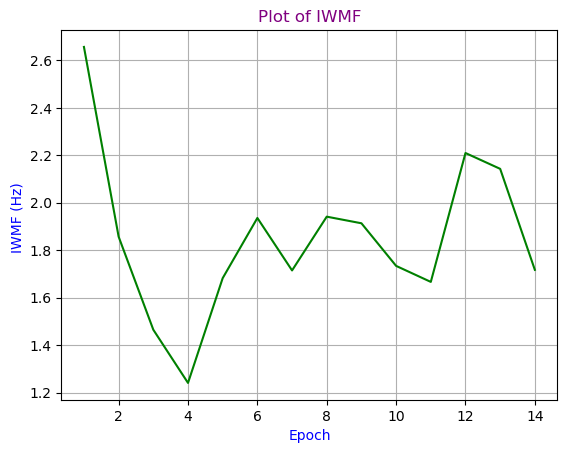

In [48]:

#plotting the Intensity weighted mean frequency for each epoch
#IWMF on the y axis and EPoch on the x-axis
plt.plot([int(x) for x in range(1, 15)], iwmf_list[:], color='green')

#y-axis and x-axis title and formatting
plt.ylabel("IWMF (Hz) ", color="blue")
plt.xlabel("Epoch", color="blue")
#title of the plot 
plt.title("Plot of IWMF", color="purple")

#show grid lines on the plot
plt.grid(True)

### RESAMPLING EEG_DATA at 500Hz to 32Hz using SCIPY'S resample function

attempting to use scipy's resample function to resample the signal to
compare how the well the resampling scheme used fared


In [49]:
#attempting to use scipy's resample function to resample the signal to
#compare how the well the resampling scheme used fared
scipysample = signal.resample(eeg_data, num=1920)
scipysample

array([-6.56057456, 13.44988887, 36.94616813, ..., 43.00305491,
       31.97129172, 27.47562931])

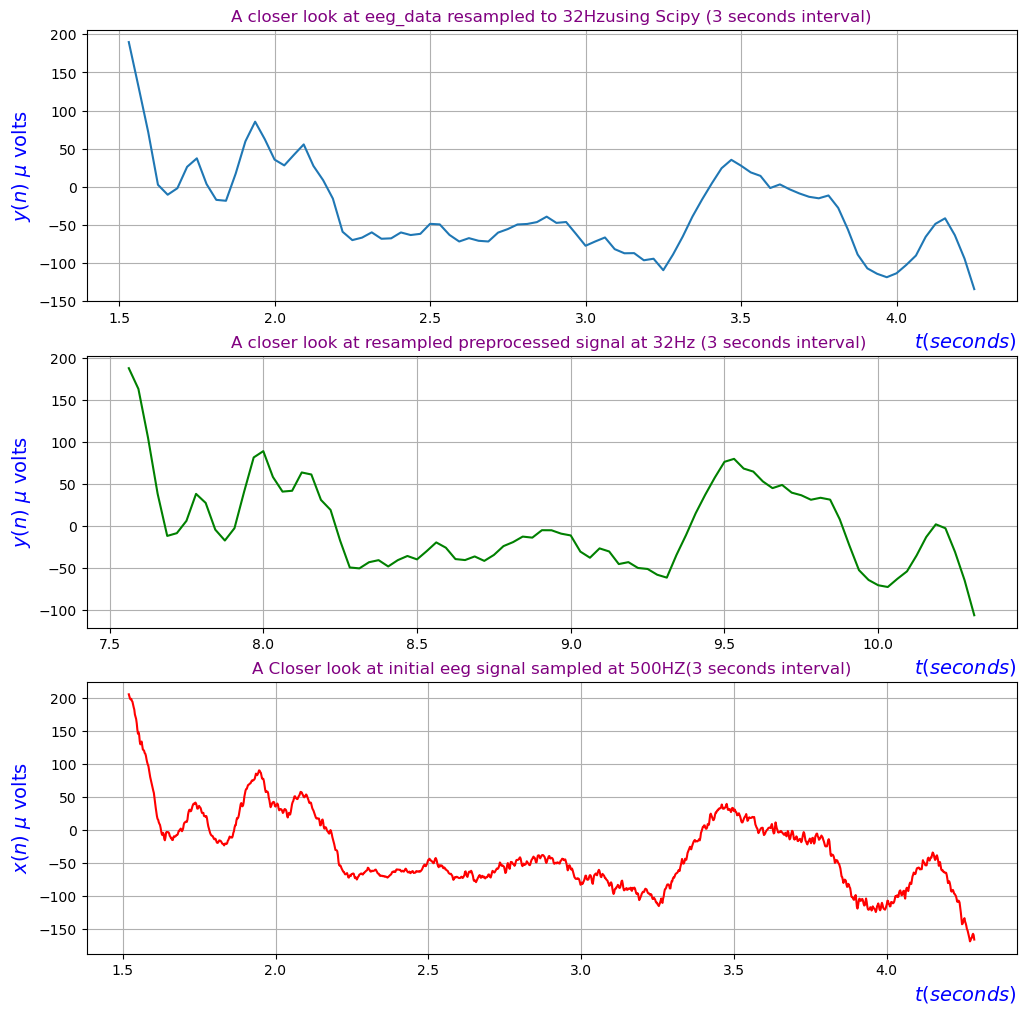

In [50]:
#setting the figure size of the plot
plt.figure(figsize=(12, 12))

#The first subplot
plt.subplot(311)

#Title of the plot and the color of the title
plt.title(
    "A closer look at eeg_data resampled to 32Hz" 
    'using Scipy (3 seconds interval)',
    color="purple"
)

#a plot from 1.5 seconds to about 4.5 seconds of a 
#slice of the scipy resampled signal at 32Hz
plt.plot((np.arange(49, 137)/32), scipysample[49:137])

#formatting and title of x and y-axis
plt.ylabel('$y(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
plt.grid(True)

#The second subplot
plt.subplot(312)
#a plot from 7.5 seconds to about 10.5 seconds of a 
#slice of the scipy preprocessed signal at 32Hz
plt.title(
    "A closer look at resampled preprocessed signal"
    " at 32Hz (3 seconds interval) ", color="purple"
    )
plt.plot((np.arange(242, 331)/32), preprocessed_signal[242:331], color="green")

#formatting and title of x and y-axis
plt.ylabel('$y(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
plt.grid(True) #show grid lines in subplot


#The third subplot
plt.subplot(313)
#a plot from 1.5 seconds to about 4.5 seconds of a 
#slice of the original signal at 32Hz
plt.title(
    "A Closer look at initial eeg signal sampled at 500HZ"
    "(3 seconds interval)", color="purple"
)
plt.plot((np.arange(760, 2144)/500), eeg_data[760: 2144], color="Red")

#formatting and title of x and y-axis
plt.ylabel('$x(n)\ \mu$ volts', fontsize=14, color="blue")
plt.xlabel(
    '$t(seconds)$', fontsize=14, color="blue", 
    horizontalalignment='right', x=1.0
)
plt.grid(True) #show grid lines in subplot

### CREATING 8 SECONDS EPOCHS WITH 50% OVERLAP FOR THE ORIGINAL EEG_DATA
 


In [51]:
#determine the number of samples in 8 s seconds and use
#this value as an argument for the create_epochs function
Epochs_data_points = (eeg_data.size / 60) * 8
print(f"There are {int(Epochs_data_points)} data samples in each epoch")

There are 4000 data samples in each epoch


In [52]:
#create 8 seconds epochs of the original eeg signals with 50% overlap
epochs_original_eeg = create_epochs(
    eeg_data, 
    samples_per_epoch=int(Epochs_data_points)
)
N_epochs = len(epochs_original_eeg)
print(
    f'There are a total of {N_epochs} epochs each containing'
    f' {epochs_original_eeg[1].size} samples'
)

There are a total of 14 epochs each containing 4000 samples


#### Plot of the Power Spectral Density for the first 9 epochs for the ORIGINAL EEG_DATA

In [53]:
def plot_epochs_spectrum(e):
    '''
      A function that plots the Power spectral density of an array of epochs

    Parameters: 
        e: Array like, list of all the epochs
    Returns:
        None
    '''
    i = 1
    plt.figure(figsize=(15, 15))
    for epoch in e:
        n = int(f"43{i}")
        f, psd =  signal.welch(
            epoch, 500, 'boxcar', 
            nperseg=1024, detrend=False
        )
        plt.subplot(n)
        psd = np.array(psd, dtype=float)
        plt.plot(f, 20*(np.log10(psd)), color="red")
        plt.title(f"Epoch {i}", color="purple")
        plt.grid(True)
        i += 1
    

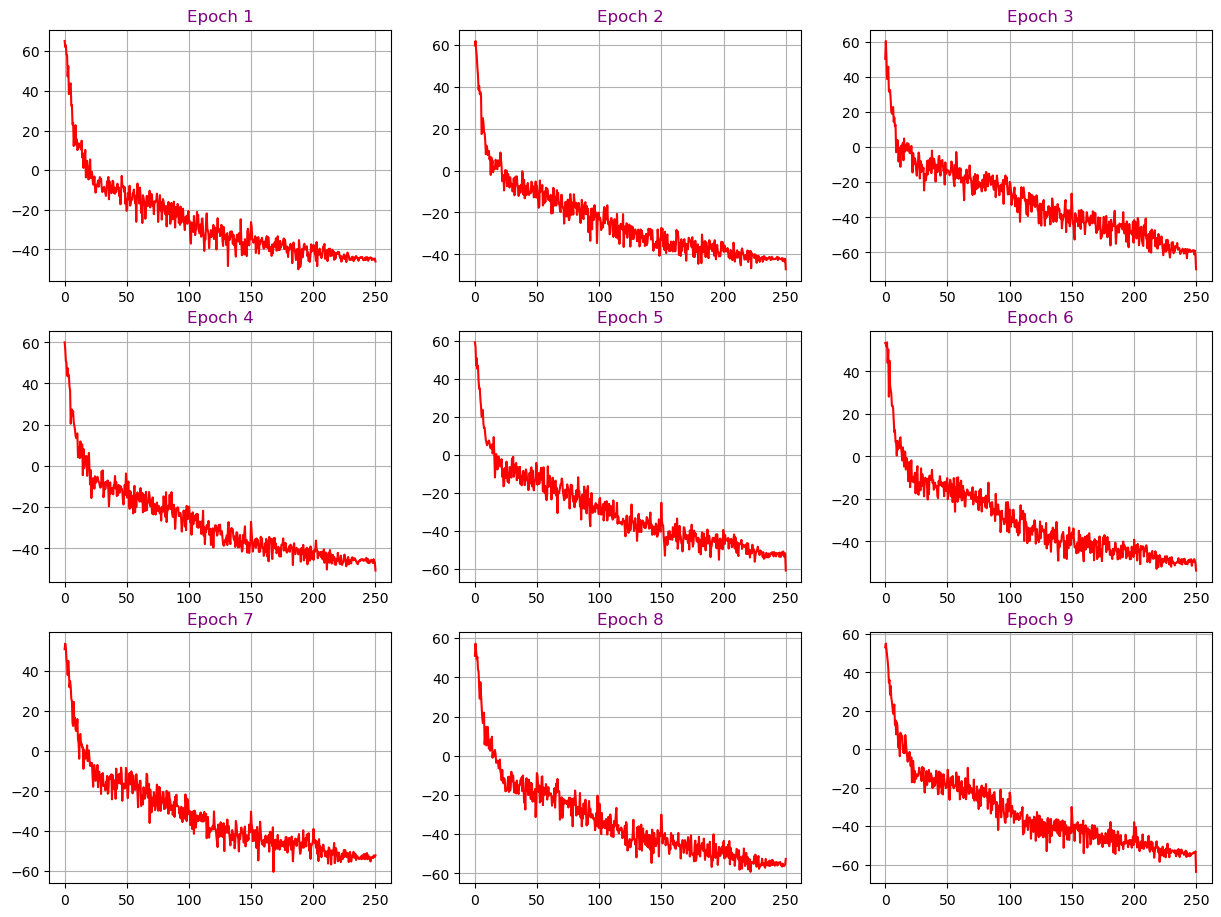

In [54]:
#uisng the plot_epochs_spectrum to plot the power spectral density 
#of the first 9 epochs of the original eeg signal
plot_epochs_spectrum(e=epochs_original_eeg[0:9])

#### Plot of the 10th to the 14th Epoch of the EEG_DATA

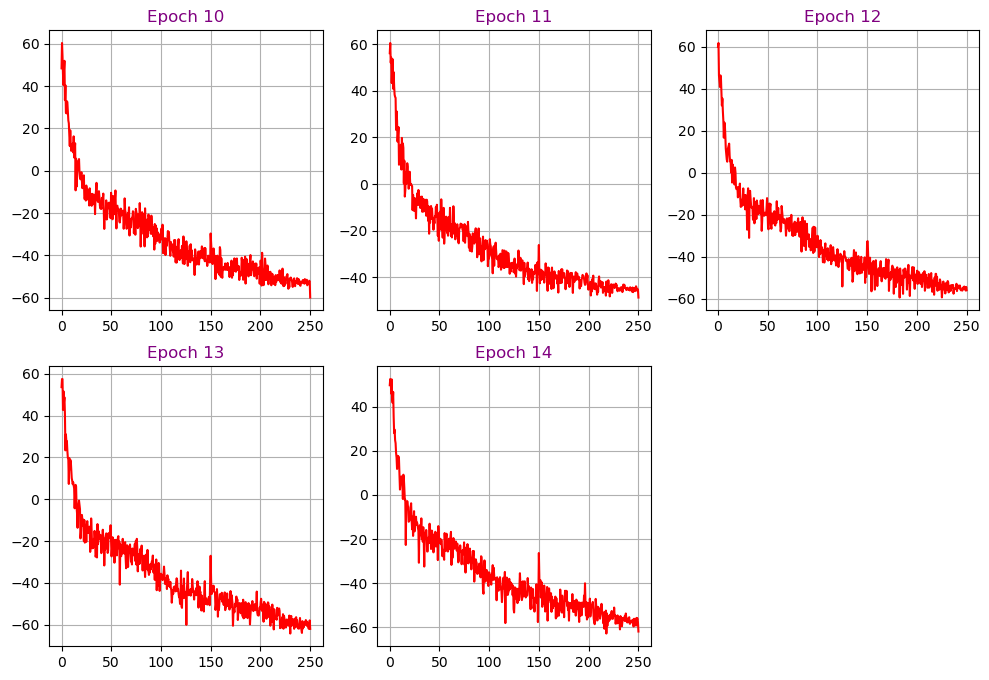

In [55]:
#procedural code section to plot the power spectral density of the 
#remaining 5 epochs of the preprocessed signal
i = 1
num = 10
plt.figure(figsize=(12,8))
for epoch in epochs_original_eeg[9:]:
        n = int(f"23{i}")
        f, psd =  signal.welch(
                epoch, 500, 'boxcar', nperseg=1024, detrend=False
        )
        plt.subplot(n)
        psd = np.array(psd, dtype=float)
        plt.plot(f, 20*(np.log10(psd)), color="red")
        plt.title(f"Epoch {num}", color="purple")
        plt.grid(True)
        i += 1
        num += 1 

#### INTENSITY WEIGHTED MEAN FREQUENCY CALCULATION for EEG_DATA

In [56]:
#The calc_iwmf function defined earlier is used once again to calculate
#a list of iwmf values for the original eeg signal this time
iwmf_list_eeg_data = calc_iwmf(epochs=epochs_original_eeg, N=2048, Fs=500)

In [57]:
print(
    "Intensity weighted mean frequency values"
    " for the original EEG_DATA sampled at 500Hz"
    f''' are: 
    {iwmf_list_eeg_data}'''
)

Intensity weighted mean frequency values for the original EEG_DATA sampled at 500Hz are: 
    [1.4615360795792323, 1.5602787201701014, 2.1130853079247167, 1.8135939445005154, 2.1391803966745173, 1.9100069454281214, 2.319504291821294, 1.8988244106539225, 2.2193039843226643, 1.6928878303072565, 2.2743468568325174, 1.2967260290685034, 1.7973139761944779, 2.021853550852224]


##### comparison of both IWMF FEATURES

Text(0.5, 0, 'Epoch')

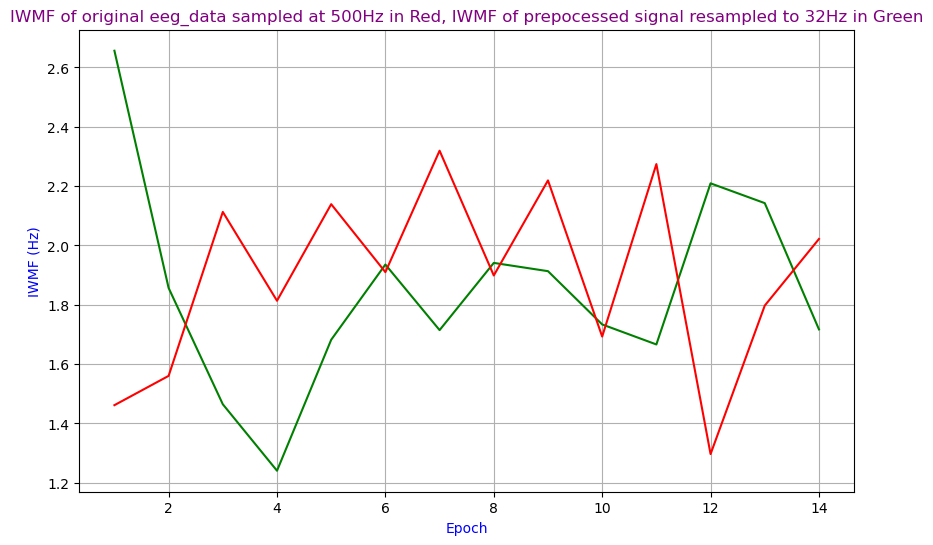

In [58]:
# plotting IWMF values for both the preprocessed signal and the original eeg
#signal

#sets the dimensions
plt.figure(figsize=(10,6))

# epochs are from 1 to 14 for both graphs on the plot
y = plt.plot([int(x) for x in range(1, 15)], iwmf_list[:], color="green")
plt.plot([int(x) for x in range(1, 15)], iwmf_list_eeg_data,  color="red")
plt.grid(True)

#set and format the title of the graph
plt.title(
    "IWMF of original eeg_data sampled at 500Hz in Red,"
    " IWMF of prepocessed signal resampled to 32Hz in Green",
    color = "purple"
)

#set and format the x and y axis of the graph
plt.ylabel("IWMF (Hz)", color="blue")
plt.xlabel("Epoch", color='blue')

##### ALL 8 EPOCHS OF THE PREPROCESSED SIGNAL AT 32 Hz

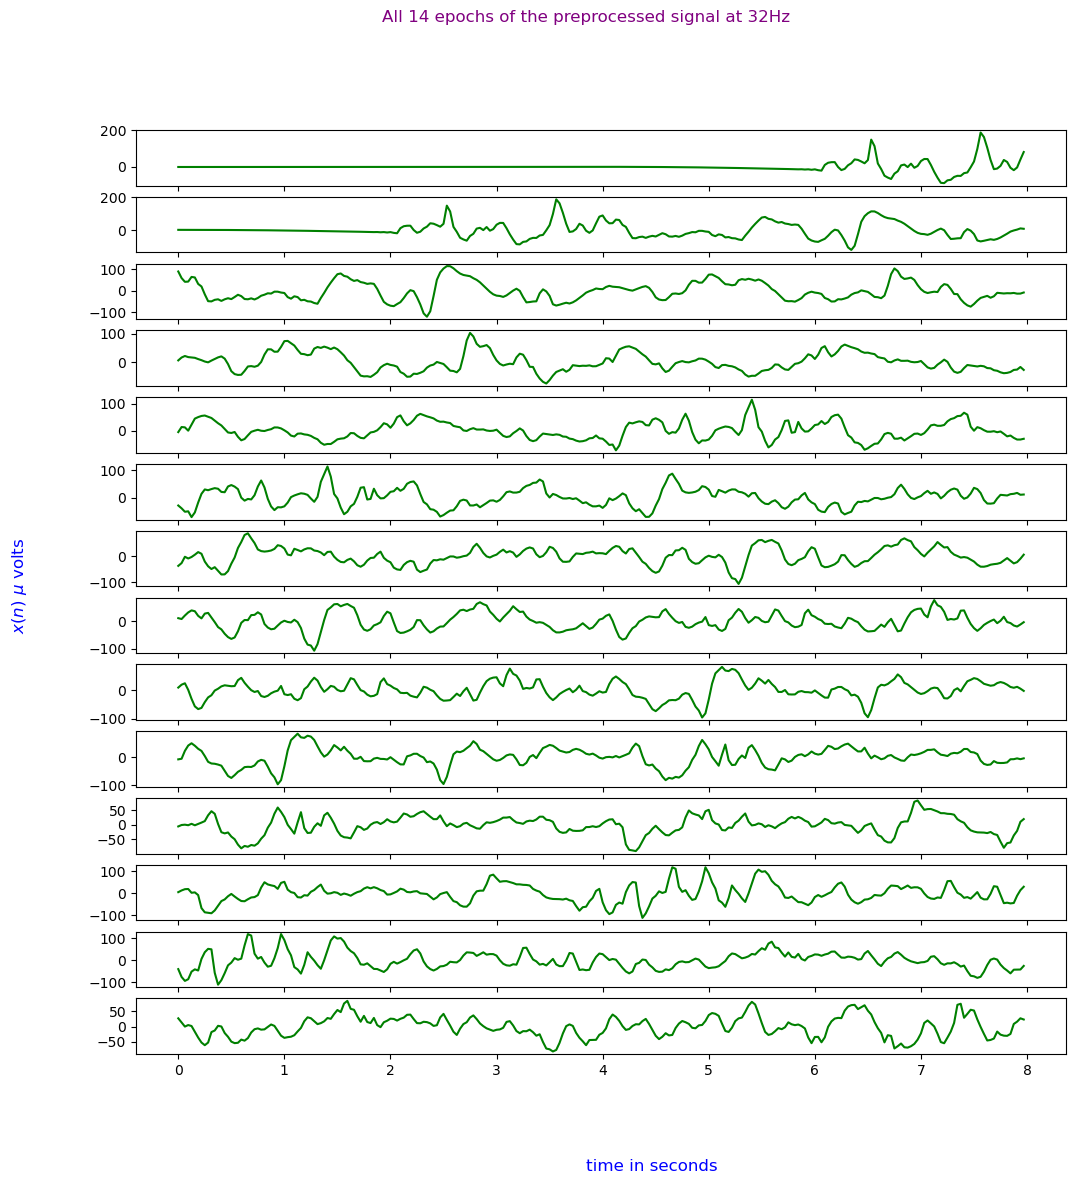

In [59]:
#using one shared x axis to plot every epoch for the preprocessed signal

time_span = np.arange(0, 8, 8/256)

fig, (
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, 
    ax8,ax9, ax10, ax11, ax12, ax13, ax14
) =  plt.subplots(14, 1, sharex=True) #share x set to True so all axis can
                                            #use one x axis 
#set dimensuons of the subplot
fig.set_figheight(12)
fig.set_figwidth(12)

#set title and format title
fig.suptitle(
    "All 14 epochs of the preprocessed signal at 32Hz", 
    color='purple'
)

#set and format x and y axis
fig.supxlabel("time in seconds", color="blue", ha='left')
fig.supylabel('$x(n)\ \mu$ volts', color = "blue")

# plot all epochs 1 through 14
ax1.plot(time_span, epochs_resampled_eeg[0], color='green')
ax2.plot(time_span, epochs_resampled_eeg[1], color='green')
ax3.plot(time_span, epochs_resampled_eeg[2], color='green')
ax4.plot(time_span, epochs_resampled_eeg[3], color='green')
ax5.plot(time_span, epochs_resampled_eeg[4], color='green')
ax6.plot(time_span, epochs_resampled_eeg[5], color='green')
ax7.plot(time_span, epochs_resampled_eeg[6], color='green')
ax8.plot(time_span, epochs_resampled_eeg[7], color='green')
ax9.plot(time_span, epochs_resampled_eeg[8], color='green')
ax10.plot(time_span, epochs_resampled_eeg[9], color='green')
ax11.plot(time_span, epochs_resampled_eeg[10], color='green')
ax12.plot(time_span, epochs_resampled_eeg[11], color='green')
ax13.plot(time_span, epochs_resampled_eeg[12], color='green')
ax14.plot(time_span, epochs_resampled_eeg[13], color='green')
    


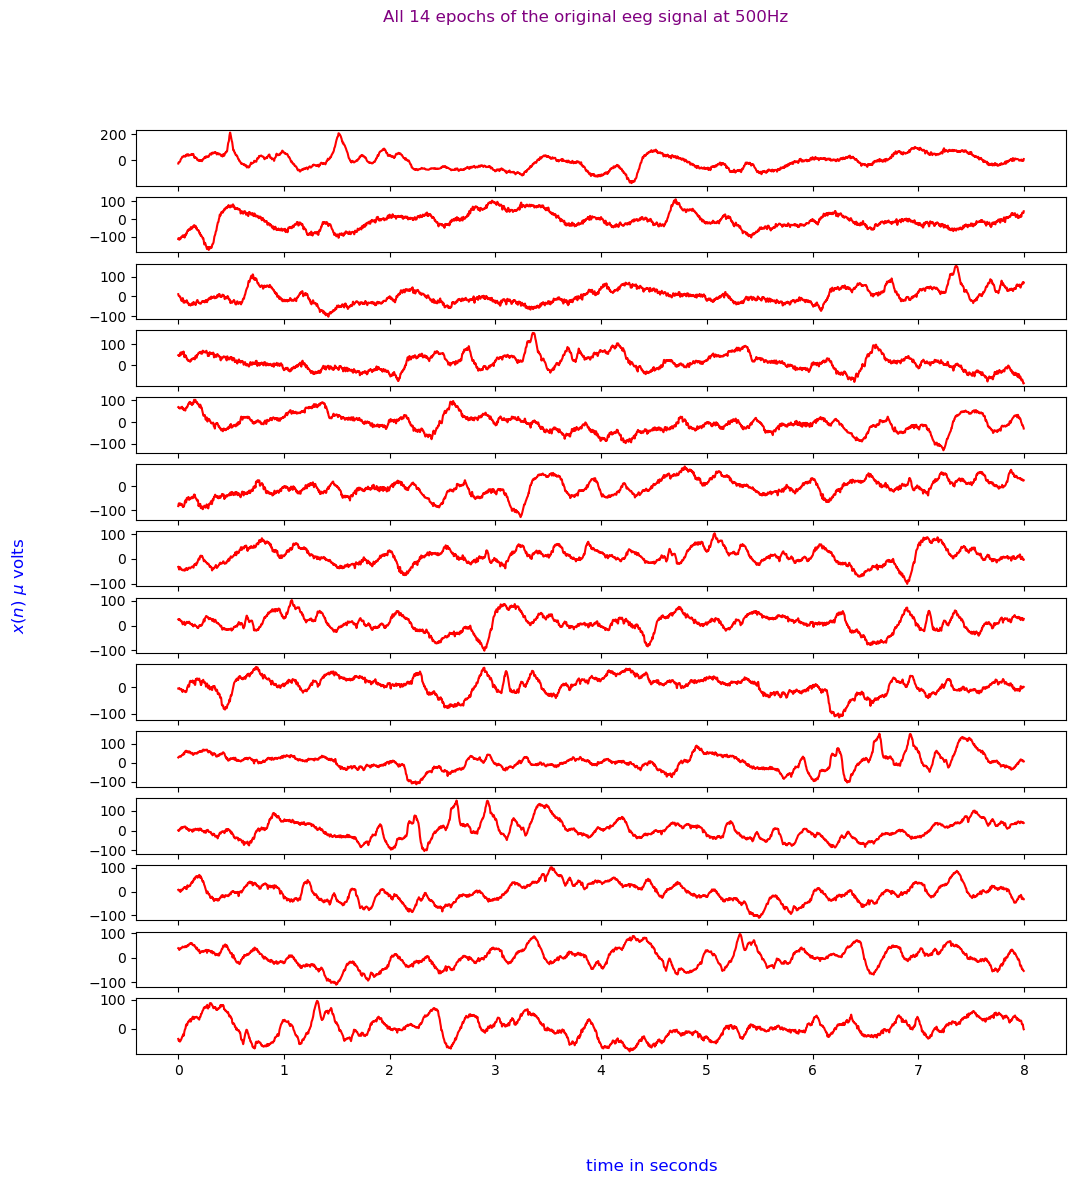

In [60]:
#using one shared x axis to plot every epoch for the preprocessed signal

time_span = np.arange(0, 8, 8/4000)

fig, (
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, 
    ax8,ax9, ax10, ax11, ax12, ax13, ax14
) =  plt.subplots(14, 1, sharex=True) #share x set to True so all axis can
                                            #use one x axis 
#set dimensuons of the subplot
fig.set_figheight(12)
fig.set_figwidth(12)

#set title and format title
fig.suptitle(
    "All 14 epochs of the original eeg signal at 500Hz", 
    color='purple'
)

#set and format x and y axis
fig.supxlabel("time in seconds", color="blue", ha='left')
fig.supylabel('$x(n)\ \mu$ volts', color = "blue")

# plot all epochs 1 through 14
ax1.plot(time_span, epochs_original_eeg[0], color='red')
ax2.plot(time_span, epochs_original_eeg[1], color='red')
ax3.plot(time_span, epochs_original_eeg[2], color='red')
ax4.plot(time_span, epochs_original_eeg[3], color='red')
ax5.plot(time_span, epochs_original_eeg[4], color='red')
ax6.plot(time_span, epochs_original_eeg[5], color='red')
ax7.plot(time_span, epochs_original_eeg[6], color='red')
ax8.plot(time_span, epochs_original_eeg[7], color='red')
ax9.plot(time_span, epochs_original_eeg[8], color='red')
ax10.plot(time_span, epochs_original_eeg[9], color='red')
ax11.plot(time_span, epochs_original_eeg[10], color='red')
ax12.plot(time_span, epochs_original_eeg[11], color='red')
ax13.plot(time_span, epochs_original_eeg[12], color='red')
ax14.plot(time_span, epochs_original_eeg[13], color='red')
    

#### Approach taken

<h2><u>SUMMARY</u></h2>

NB: _color code for graphs: red plots refer to the original signal, green plot refer to preprocessed signal/signal undergoing processing and blue refers to signal upsampled using scipy's resample function_

A summary of the process used for preprocessing the eeg discrete signal is as follows:

1. Upsampling the signal from 500Hz to 4000Hz, by inserting 7 zeros between consecutive samples (i.e between every x(n) and x(n +1)) in the 500 Hz signal
2. Using a low pass interpolation filter to smoothen the upsampled signal by interpolating the non-zero values to grow the zeros to the final interpolated waveform. Gain of the lowpass filter is L, the interpoloation factor
4. One stage decimation-A downsampling of the upsampled signal from 4000Hz to 32Hz (the resampled signal), selecting one sample for every M sample, i.e removing (M-1) samples in every M samples.
5. Filtering the resampled signal with a High pass filter to get rid of extra artifacts of low frequency.
6. Splitting the resampled 32Hz signal into 8 seconds epochs with 50% overlap
6. Determining IWMF of (Intensity weighted mean frequency) of each epoch and plotting this feature

<h3><u>Procedures and Description:</u></h3>
The following libraries were used to pre-process the eeg digital signal: pandas, numpy, matplotlib, scpy, math, mpltools.
First and foresmost the data representing the eeg discrete siganl measurement contained in an xlsx file named "FIle_4.xlsx" was extracted and used to create a DataFrame object in cell 2 which was later turned to an array using numpy.
Then, the code in cell 3 was used to display the length of the recording. Sampling frequency refers to the number of samples per second...Since the recording is said to have been sampled at a frequency of 500 Hz. The number of data points/samples in the whole recording is divided by 60 seconds and the sampling frequency to give a duration of one minute.

<em><u>Determining Interpolation and Decimation factors:</u></em>

Before preprocessing the time-domain plot of the signal was done to give an overview of its characteristics in the time domain. A power spectral analysis was also done on the signal to determine the distribution of power into frequency components composing that signal.
Then the preprocessing was done. The LCM of the current sampling frequency and the desired sampling frequency was calculated (500Hz and 32Hz respectively to yield a result of 4000Hz).This value: 4000, was used to calculate the interpolation and decimation factors

$$ L = \frac{400}{32} = 8\text{                   .....interpolation factor}$$

$$ M = \frac{4000}{8} = 125\text{                 .....decimation factor}$$


This 4000Hz the intermediate sampling frequency for the two stage resampling which involves a one stage interpolation and a one stage decimation. Generally decimation and interpolation could be done in different steps for example insteading of interpolating by a factor 100 once a designer could do so in 3 steps (4, 5, 5) in order to reduce complexity by reducing the total number of filter taps. But the approach for this design was to used one stage (for both interpolator and decimator) to reduce the amount of filters used.

A custom function was created to perform this upsampling process, taking in 3 arguments; the recording to be sampled, the desired up sample frequency and the current sampling frequency of the recording. The custom function is named "upsample". The desired upsample frequncy is the intermediate frequency 4000. The "upsample" function returns an array which is the upsampled signal with a sample frequency of 4000 Hz.

The signal was plotted in the time domain in cell 12, and a frequncy analysis was done using scipy's welch function. The frequency analysis (power spectral estimation) shows the stretch theorem, as spectral copies (images) are created, that is L numbers of spectra after upsampling. 

<em><u>Determining Low Pass Interpolation/Anti-imaging filter parameters:</u></em>

Right after the upsampling the now upsampled signal was passed through a a Low Pass anti-imaging or interpolation. Just upsampling does not interpolate in a literal sense but passing the upsampled signal actually does this, this process i.e interpolation is also described as zero-packing in digital signal processing. The lowpass filter specifications really is determined by the either the interpolator or decimator; which ever gives the more stringent design (a smaller transition band), which has the higher factor determines the stopband that would be used for the filter design. Here the decimator factor is higher so the low pass filter specifications were determined by the decimator this can be proved below by calculating the stopbands as shown belo




$F_{l.p stopband(L)} = \frac{4000}{2L} = 250Hz $

$F_{l.p stopband(M)} = \frac{4000}{2M} = 16Hz $


$ΔF_{l.p filter (L)} = 250 - 13 = 237Hz $

$ΔF_{l.p filter (M)} = 16 - 13 = 3Hz  $


<b>*from the calculations above the decimator gives a smaller transition frequency i.e a more stringent design</b>




 Determining B as 13?
 B was chosen as 13 because neonatal EEG seizures range from 0.5Hz to 13Hz with the dominant frequency of seizure between 0.5 to 6Hz so choosing B as 13 is just fine!
 

 A function was written in cell 14 named "lp_filter_specs" to handle computing the filter specifications highlighted in the equation above were written to return a list of transition bandwidth, cut off frequency, Bandwidth, and stopband for the interpolation low pass filter. The last filter parameter 'number of taps' was calculated lastly outside this function using a hamming window to get a value of 4401, number of filter taps has to be odd for linear positive symmetry of the filter. It is important to mention that a stopband attenuation of 53 dB was required hence the reason the hamming window was chosen for window FIR filter design. 
 


 $$\text{Number of taps}_{\text{hamming window}} = \frac{3.3}{ΔF}\text{   } \text{rounded up to the nearest odd integer}$$


$\text{Number of taps}_{\text{hamming window}} = \frac{3.3\times4000}{3} $


$\text{Number of taps}_{\text{hamming window}} = 4401 $

 



<em><u>computing filter co-efficients</u></em>
 The coefficients of the filter were calculated using scipy's firwin function. The impulse response of the Low pass filter and the frequency response are shown in the output of cell 20.

After filtering it can be shown that the low pass filter got rid of the images in the frequency analysis done in cell 23, the power spectral density shows the duplicate spectra all gone hence the reason the interpolating low pass filter is also called an anti-imaging filter.

A comparison of the original eeg signal, the upsampled signal, and the output of the interpolation filter are show for a seconds...the upsampled unfiltered signal can be seen to have zero values ticked in red but right after filtering all this is gone shown in the third plot in cell 24. The plot is now average out in the time domain, with all points properly interpolated.


<em><u>benefits of decimating before high pass filtering</u></em>
Then decimation was done (a downsampling from 4000Hz to 32Hz), just like in the upsampling done a function named 'down_sample' was defined for this function  by only selecting every M + 1 sample from the 4000Hz signal starting from the zeroth value i.e x(n), x(n+M), x(n + 2M) etc. where n = 0. Decimation helps in removing excess bandwidth and reducing sampling frequency, and also helps in reducing computational cost in processing and storing the signal that is why a high pass fitering is not conventionally done after the low pass interpolation filtering  for eeg signals. Doing it before would decimation would require more storage as the upsampled signal contains more samples.

<em><u>why do eeg signals need to be filtered in the first place</u></em>
After the decimation a High Pass FIltering is done. Why is high pass filtering done on eeg signals? First and foremost when taking EEG measurement, different type of artifacts, such as: eye blinks, muscle movements, movements of EEG sensors, power line interference, environment and so on may be added to the measured EEg signals that is why low pass and high pass filtering are needed in the first place. The Low pass Interpoloation filter already described takes care of frequencies above 13 Hz like those contributed by some electrical artifacts. There is usually no cerebral activity below 0.5Hz, signals that exist below 0.5Hz are usually motion like blinking of the eyes or other electrical activity. Hence the reason to use a low pass filter with passband edge frequency of 0.5Hz, transition band 0.5Hz and cut-off frequency of 0.25


<em><u>determining parameters of the High pass filter</u></em>
$$F_{cut-off\text{High pass filter}}  = 0.5 - \frac{Δf}{2} $$

$$\text{where Δf} = 0.5 Hz$$


 $$F_{cut-off\text{High pass filter}} = 0.25 Hz$$
 
 
 
 It was desired to have a stopband attenuation of 75dB so the blackman window was used and the number of filter taps were calculated in cells 31 and 32 as 353.. its odd because for the windows method it is desirable to have a Linear filter with positive symmetry.


 
 $$\text{Number of taps}_{\text{blackman window}} = \frac{5.5}{ΔF}\text{   } \text{rounded up to the nearest odd integer}$$


$\text{Number of taps}_{\text{blackman window}} = \frac{5.5\times32}{0.5} $


$\text{Number of taps}_{\text{blackman window}} = 353 $



**NOTE: If high pass filtering was done immediately after the interpolation the number of taps would have been**

$\text{Number of taps}_{\text{blackman window}} = \frac{5.5\times4000}{0.5} $


$\text{Number of taps}_{\text{blackman window}} = 44,001 $


**Forty-Four thousand filter taps for the high pass filter which is costly computationally. This further proves the point made earlier in this description that decimation is highly beneficial as it saves storage and reduces computational complexity (353 filter taps used against 44,001)**




 

Then the firwin function was used to calculate the filter co-efficients, then the resampled signal (at 32) is multiplied by the coefficients of the filter in cell 35 and returns an array representing the final preprocessed eeg signal.
A plot of both the resampled signal at 32Hz and the original signal at 500Hz were shown in figure 36. The resmapled siganl was plotted in green while the original signal was plotted in red. The time delay is clearly noticeable this is as a result of the the filtering. There is a zoomed in plot in the output of cell 37 expatiatiing on the output of 36.


<u>_Calculating the number of epochs present, estimation spectrum of each epoch for the resampled preprocessed signal and the original eeg signal at 500Hz_</u>

After resampling the signal the resampled signal now 32Hz (1,920 samples in 60 seconds) was split into 8 seconds Epochs of 50% overlap. in 8 seconds there 256 samples. 

$$\text{number of samples in 8 seconds} = \frac{1920 \times 8}{60}$$
$$\text{256 samples in 8 seconds or one epoch for the resampled signal at 32 Hz}$$
                               



A function was written to calculate the total number of epochs in the one minute span, the function 'create_epochs' was used to create the epochs from the resampled signal and return the epochs created in a list.. The function was called in cell 40 and the returned the epochs in a list. The power spectral density of every epoch was graphed 1 to 14. Then the intensity weighted mean frequency (IWNF) was calculated for each epoch, using its respective power spectral density


 $ f_{m}  = \frac{\sum\limits_{i=0}^{N/2 -1} p_{i}idf}{\sum\limits_{i=0}^{N/2 -1}pi} $
  
  
 where df = $ \frac{F_{s}}{N} $
 
 
 N is the total number of frequency bins used, N = 256 DFT points for an 8 seconds epoch at 32Hz

 the formula above was used to create the function 'calc_iwmf' in cell 56, for the resampled signal N used was 256, the reason being that for welch method, it uses a windows of a length N specified by the argument 'nperseg', and the length has to be an exponent of 2, less than the length of the signal to be analysed. How large the length of the window determines the resolution of the power spectral density, so using N = 256 is just fine and it is passed in the argument 'nperseg' the 'cal_iwmf' returns the iwmf for every epoch passed to the function. Similarly, when computing the IWMF for each 8 second epoch of the original eeg signal at 500Hz the value for N was choosen at 2048 (i.e nperseg=2048) this is beacause 2048 is the exponent of 2 closest lower value to the length of each epoch of the original signal (4000 samples).



$$\text{number of samples in 8 seconds} = \frac{30000 \times 8}{60}$$

$$\text{4000 samples in 8 seconds or one epoch of the original signal at 500Hz}$$



The iwmf was later plotted for the entire 60 seconds (all 14 epochs) the plot has a maximum iwmf value of 2.66 at the FIrst, the IWMF feature of the original eeg signal had a peak value of 2.32 at the 7th epoch

**<em>comparison of scipy's resampling scheme to the scheme used in this design</em>**

The plot in cell 50 shows how the resampling scheme used in this design stacks up against scipy's resample function, the resmpling scheme zoomed in for a 3 second period in the plot of the cell looks highly identitical to the signal resampled by scipy but the time delay clearly shows in the plot of preprocessed signal (the one sampled with the scheme described above), this delay is as a result of the signal being filtered. A linear phase filter delays all frequency components by the same amount, It can be seen that the resampling scheme delays the signal by some 6 seconds. (7.5seconds - 1.5seconds )

#### CONCLUSION
The Aim of this report was to do a preprocessing of an eeg signal involving an efficient resampling scheme (from 500Hz to 32Hz) for the design of an Automated Seizure Detection Algorithm in babies. The preprocessing scheme is heavily focused on multirate digital signal processing only and segmentation without the removal of useless channels.
In multirate digital signal processing the sampling rate of a signal is tranformed to increase the efficiency i.e reduce computational complexity and storage of various signal processing schemes. Expansion or up-sampling followed by an interpolation increases the sampling rate and decimation or down-sampling reduces the sampling rate.


<u>What is preprocessing?</u>

Preprocessing involves transformation of raw data in this case the original eeg data into a format that is more suitable for analysis and more readable. This involves multirate signal processing and removing noise from the eeg signal to get the neural signals.

__Findings:__

1. _Why the side with a higher factor dictates the interpolation filter parameters?_

It can be seen from the summary section that a higher factor implies a smaller transition bandwidth (when factor L = 8, transition bandwidth was 3 Hz, and when factor M = 125 transition bandwidth was 237 Hz), and a smaller transition frquency would have more filter taps as the relationship between transistion bandwidth and filter tap is inverse for every window design as discussed in this module. The benefit of a smaller transition frequency is although it would be more complex, it certainly guarantees enough attenuation for frequencies outside the range of interest (frequencies greater than B which is a more stringent design-enough attenuation). Hence because M was much more larger than L, the stopband frequency of the decimator determined the parameters for the low pass interpolation filter.

2. _What does the low pass interpolation filter do_

from the graphs it can be seen that the low pass interpolation filter grows the zero value after upsampling due of the Gain L of the filter which was 8 for this design. The Low pass interpolation filter also gets rid of the spectral images and this was seen after plotting a spectral power density of the filtered up-sampled signal (8 spectras vs 1 spectra)

3. _Using a high pass filter after decimation saves storage and computation_

From the summary section it can be seen that doing a high pass filtering after decimation saved (44,001 - 4,101 = 40,000) at least 40,000 computation operations. i.e at least 40,000 lesser operations was done in filtering the signal after decimation as opposed to doing it before.

4. _Linear Phase FIR filters introduce time delay_

Plotting the epochs of both the original signal and the preprocessed signal shows some 6 second delay in the preprocessed signal

5. _The resampling scheme faired nice in comparison to scipy's resample function_


6. _The preprocessed signal and the original eeg signal had different IWMF features after segmentation, this means that each pair of epoch of both the original signal and the preprocessed signal are different_


__Improvements__

To improve on this design, a multistage decimation could be done involving two stages (M1 = 5 and M2 = 125) to further reduce computational cost







